# Second try, Metadata

In [1]:
#TensorFlow
import tensorflow as tf

#Standarts
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
csvpath   = r'D:\Downloads\NIH'
imagepath = r'D:\Downloads\NIH\images-224\3channel'

In [3]:
df = pd.read_csv(os.path.join(csvpath,'Data_Entry_2017.csv')).drop(['Unnamed: 11'], axis = 1)
errorlist = pd.read_csv('errorlist.csv')
df.set_index('Image Index', inplace = True)
df.drop(index = errorlist['0'], inplace = True, axis = 0)
df.reset_index(inplace = True)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143


In [4]:
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|')[0] if '|' in x else x)

In [5]:
CLASS_NAMES = pd.get_dummies(df['Finding Labels']).columns
CLASS_NAMES

Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [6]:
df['Sex']  = pd.get_dummies(df['Patient Gender'])['F']
df['View'] = pd.get_dummies(df['View Position'])['AP']
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Sex,View
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,0,0
1,00000001_001.png,Cardiomegaly,1,1,058Y,M,PA,2894,2729,0.143,0.143,0,0
2,00000001_002.png,Cardiomegaly,2,1,058Y,M,PA,2500,2048,0.168,0.168,0,0
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,0,0
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,1,0


# CNN

In [102]:
data_dir = r'D:\Downloads\NIH\images-224\3channel\*'

In [103]:
list_ds = tf.data.Dataset.list_files(data_dir)

In [104]:
for f in list_ds.take(5):
    print(f.numpy())

b'D:\\Downloads\\NIH\\images-224\\3channel\\Atelectasis\\00008791_000.png'
b'D:\\Downloads\\NIH\\images-224\\3channel\\No Finding\\00021047_000.png'
b'D:\\Downloads\\NIH\\images-224\\3channel\\Atelectasis\\00005064_000.png'
b'D:\\Downloads\\NIH\\images-224\\3channel\\No Finding\\00013774_061.png'
b'D:\\Downloads\\NIH\\images-224\\3channel\\No Finding\\00011553_028.png'


In [105]:
image_count = len(list(list_ds))
image_count

111616

In [106]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [107]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [108]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [109]:
def get_metadata(file_path):    #Demora muito, temos que refinar
    #get the metadata
    parts = tf.strings.split(file_path, os.path.sep)
    mdt = df[df['Image Index'] == parts[-1]]['Sex'].values, df[df['Image Index'] == parts[-1]]['View'].values
    return mdt

In [110]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    #mtd = get_metadata(file_path)
    return img, label #,mtd

In [111]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [112]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
        ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [113]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [114]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

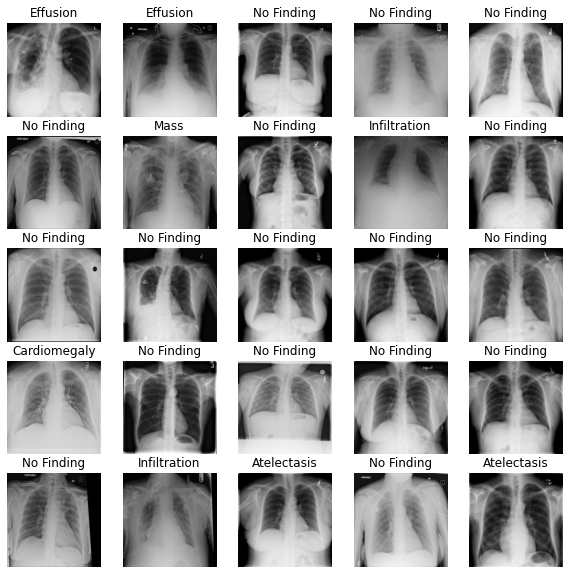

In [115]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [116]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [117]:
base_model.trainable = False

In [118]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),          #Adicionar metadados aqui
  tf.keras.layers.Dense(15, activation='softmax')
])

In [119]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [120]:
epochs = 1

history = model.fit(train_ds, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=epochs)

Train for 3488.0 steps
   1/3488 [..............................] - ETA: 3:23:55

UnknownError: 2 root error(s) found.
  (0) Unknown:  NewRandomAccessFile failed to Create/Open: D:\Downloads\NIH\images-224\3channel\Pleural_Thickening : Acesso negado.
; Input/output error
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) Unknown:  NewRandomAccessFile failed to Create/Open: D:\Downloads\NIH\images-224\3channel\Pleural_Thickening : Acesso negado.
; Input/output error
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_731103]

Function call stack:
distributed_function -> distributed_function
